# Preventing leaking labels
A common problem when segmenting cells in images with membrane staining is _leaking_ labels. When using algorithms such as the [seeded watershed]() these leakes can be prevented by filtering the image, e.g. using a local maximum filter.

In [1]:
import napari_segment_blobs_and_things_with_membranes as nsbatwm
from skimage.data import cells3d
import stackview
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

For demonstration purposes we use the [cells3d example image from scikit-image](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.cells3d). 

In [2]:
image = cells3d()[:,0]
image.shape

(60, 256, 256)

We look at a slice of it in a Z-Y. For code-simplicity we leave out the plot axis labels after this figure.

Text(0, 0.5, 'Z')

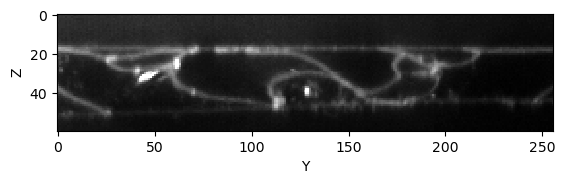

In [3]:
cle.imshow(image[:,:,128], max_display_intensity=20000, continue_drawing=True)
plt.xlabel("Y")
plt.ylabel("Z")

When applying the seeded-watershed algorithm to this dataset (in 3D), we can see that some labels leak in Z. They merge with the region outside the tissue layer.

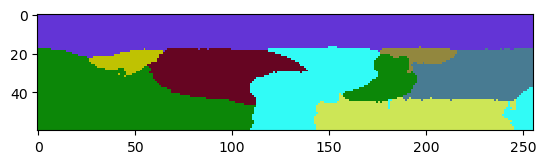

In [4]:
reference_labels = nsbatwm.local_minima_seeded_watershed(image, spot_sigma=9)

cle.imshow(reference_labels[:,:,128], labels=True)

The problem can be reduced by applying a maximum-filter to the raw image. It will lead to thicker membranes, and thus to a lower chance that the watershed algorithm can leak through holes in the membrane.

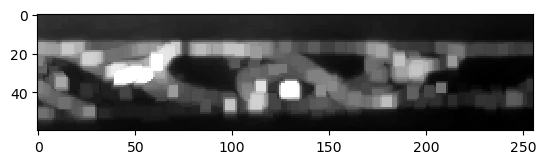

In [5]:
thicker_membranes = nsbatwm.maximum_filter(image, radius=2)

cle.imshow(thicker_membranes[:,:,128], max_display_intensity=20000)

The resulting label image has less leaking labels, but also lost accuracy of the label borders in all directions. 

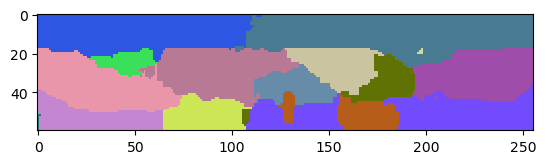

In [6]:
labels1 = nsbatwm.local_minima_seeded_watershed(thicker_membranes, spot_sigma=9)

cle.imshow(labels1[:,:,128], labels=True)

The leaks often appear to happen in the Z-direction only which is an effect of the [point-spread-function](https://en.wikipedia.org/wiki/Point_spread_function) of common microscopy techniques. It is typically anisotropic and thus, the microscope cannot capture the membrans in Z as good as in X and Y.

To deal with this leaking-labels issue in X and Y only and save some of the accuracy in Z, we need to apply a maximum filter where we can specify different radii in X,Y and Z.

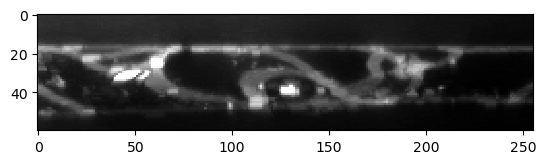

In [7]:
thinker_membranes_in_x_y = cle.maximum_sphere(image, radius_x=2, radius_y=2, radius_z=0)

cle.imshow(thinker_membranes_in_x_y[:,:,128], max_display_intensity=20000)

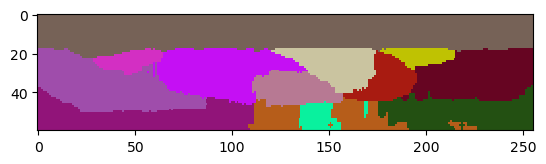

In [8]:
labels2 = nsbatwm.local_minima_seeded_watershed(thinker_membranes_in_x_y, spot_sigma=9)

cle.imshow(labels2[:,:,128], labels=True)

## Excluding labels on image edges in Z
Images of single tissue layers are commonly acquired in a way that we see some pixels and later segmented labels out of the tissue top and bottom (in Z). We can remove those labels while keeping those which touch the image border in X and Y explicitly.

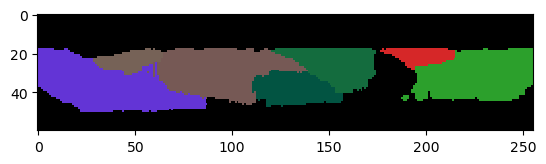

In [9]:
corrected_labels = cle.exclude_labels_on_edges(labels2, 
                                               exclude_in_x=False, 
                                               exclude_in_y=False, 
                                               exclude_in_z=True)

cle.imshow(corrected_labels[:,:,128], labels=True)

Obviously, we still loose one cell that was leaking in the area below the tissue. It might be impossible to retrieve a picture-perfect result though.